In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# euclidian distance in each layer, block dim 8,8,8,8, xu - xv, initialized with node degree

In [16]:
from modules import *
from utils import *

In [17]:
torch.cuda.is_available()

True

In [18]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [19]:
nvidia_smi.nvmlInit()
cuda = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

In [20]:
config = Config('config-Copy29.json')

In [21]:
config[...]

{'name': 'degree_dir_u_8888',
 'batchsize': 80,
 'epoch': {'start': 59, 'end': None},
 'lr': {'initial': 0.001,
  'decay_rate': 0.99,
  'decay_step': 1,
  'override': None},
 'log_period': 1,
 'test': {'name': 'degree_dir_u_8888',
  'epoch': 302,
  'out_prefix': 'degree_dir_u_8888'}}

In [22]:
class GNNBlock(nn.Module):
    def __init__(self, feat_dims, bn=False, act=True, dp=None, euclidian=None, direction=False, residual=False):
        super().__init__()
        self.euclidian = euclidian
        self.direction = direction
        self.residual = residual
        self.gnn = nn.ModuleList()
        self.n_layers = len(feat_dims) - 1
        
        for idx, (in_feat, out_feat) in enumerate(zip(feat_dims[:-1], feat_dims[1:])):
            in_efeat_dim = 2 + direction * (feat_dims[ids] if euclidian == 'prev' 
                                            else feat_dims[0] if euclidian == 'first' 
                                            else 0) + (self.euclidian is not None)
            self.gnn.append(GNNLayer(in_vfeat=in_feat, 
                                     out_vfeat=out_feat, 
                                     in_efeat=in_efeat_dim, 
                                     bn=bn, 
                                     act=act, 
                                     dp=dp))
        
    def forward(self, v, data):
        vres = v
        for layer in range(self.n_layers):
            e = get_edge_feat(v if self.euclidian == 'prev'
                              else vres if self.euclidian == 'first'
                              else None, 
                              data, euclidian=self.euclidian is not None, 
                              direction=self.direction)
            v = self.gnn[layer](v, e, data)
        return v + vres if self.residual else v

        
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        h_dim = 8
        in_dim = 8
        euclidian = 'first'
        direction = True
        
        self.block0 = GNNBlock(feat_dims=[1, 8, in_dim], bn=True, dp=0.2)
        self.block1 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block2 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block3 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block4 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block5 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block6 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block7 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block8 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block9 = GNNBlock(feat_dims=[in_dim,h_dim,h_dim,in_dim], bn=True, dp=0.2, euclidian=euclidian, direction=direction, residual=True)
        self.block10 = GNNBlock(feat_dims=[in_dim, 8], bn=True)
        self.block11 = GNNBlock(feat_dims=[8, 2], act=False)

    def forward(self, data, output_hidden=False, numpy=False):
#         b = torch.rand_like(data.x) * 2 - 1
        
        v0 = self.block0(data.x, data)
        v1 = self.block1(v0, data)
        v2 = self.block2(v1, data)
        v3 = self.block3(v2, data)
        v4 = self.block4(v3, data)
        v5 = self.block5(v4, data)
        v6 = self.block6(v5, data)
        v7 = self.block7(v6, data)
        v8 = self.block8(v7, data)
        v9 = self.block9(v8, data)
        v10 = self.block10(v9, data)
        v11 = self.block11(v10, data)     
        
        hidden = [data.x, v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11]
        if numpy:
            hidden = list(map(lambda x: x.detach().cpu().numpy(), hidden))
        return hidden if output_hidden else hidden[-1]

In [23]:
G_list, data_list = load_processed_data(G_list_file='G_list_degree.pickle', 
                                        data_list_file='data_list_degree.pickle')

In [13]:
loader = DataLoader(data_list[:10000], batch_size=config['batchsize'],shuffle=True)
loss_ep = []

In [11]:
if not os.path.isdir(f"../ckpt_{config['name']}"):
    os.mkdir(f"../ckpt_{config['name']}")

In [14]:
start_epoch = config['epoch']['start']
if start_epoch == 0:
    model = Model().to(device)
else:
    model = torch.load(f"../ckpt_{config['name']}/epoch_{start_epoch}.pt").to(device)
criterion = EnergyLossVectorized()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['initial'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                            step_size=config['lr']['decay_step'], 
                                            gamma=config['lr']['decay_rate'])
print("=" * 50, file=open(f"{config['name']}.log", "a"))
epoch = start_epoch + 1
with tqdm(total=len(loader), smoothing=0) as progress:
    while True:
        if config['lr']['override'] is not None:
            optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['override'])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                        step_size=config['lr']['decay_step'], 
                                                        gamma=config['lr']['decay_rate'])
        progress.reset()
        progress.set_description(desc=f"[epoch {epoch}/{config['epoch']['end']}]")
        train_loss = train(model, criterion, optimizer, loader, data_list, device, progress, cuda)
        loss_ep.append(train_loss)
        scheduler.step()
        if epoch == 1 and config['log_period'] != 1:
            print(epoch, loss, scheduler.get_lr(), file=open(f"{config['name']}.log", "a"))
        if epoch % config['log_period'] == 0:
            torch.save(model, f"../ckpt_{config['name']}/epoch_{epoch}.pt")
            test_loss = []
            for val_idx in range(11000, len(G_list)):
                node_pos,loss = evaluate(model, data_list[val_idx], criterion, device)
                test_loss.append(loss)
            print(f'{epoch}, train: {train_loss}, val:{np.mean(test_loss)}，{scheduler.get_lr()}', 
                  file=open(f"{config['name']}.log", "a"))
        if epoch == config['epoch']['end']:
            break
        epoch += 1

KeyboardInterrupt: 

# Performance Testing

In [24]:
model = torch.load(f'../ckpt_{config["name"]}/epoch_{config["test"]["epoch"]}.pt', map_location=torch.device(device))
criterion = EnergyLossVectorized()
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [25]:
ground_truth = pd.read_csv('scaled_gt_loss.csv', index_col=0)
folder_name = f'{config["test"]["name"]}_test'
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)


63907.033569999985 2015681.690864694
409.29539471671796 12929.855669169327


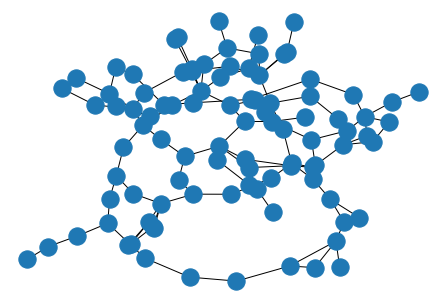

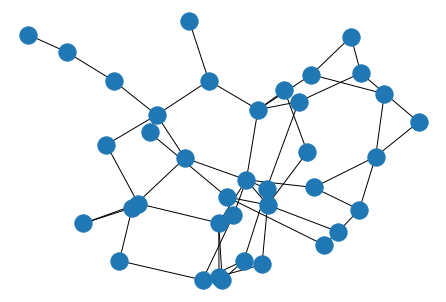

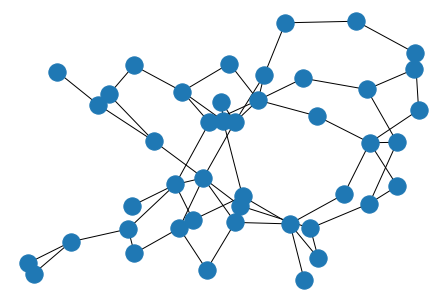

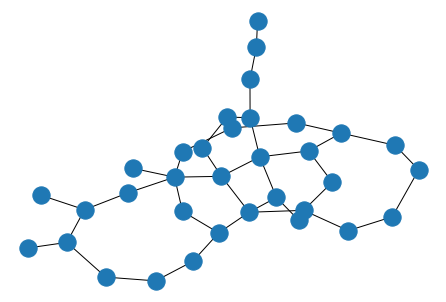

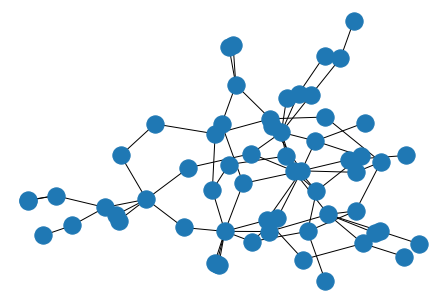

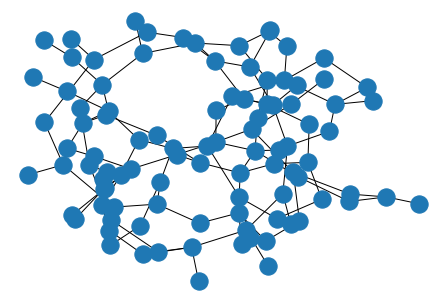

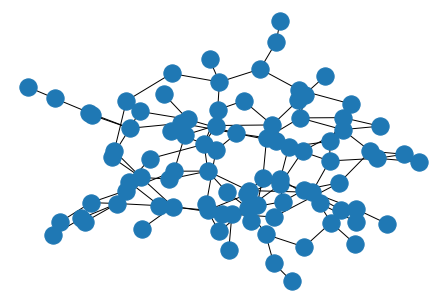

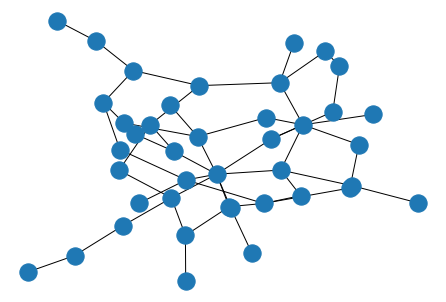

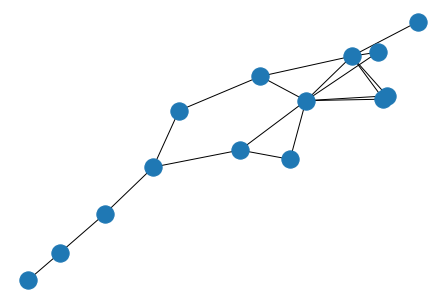

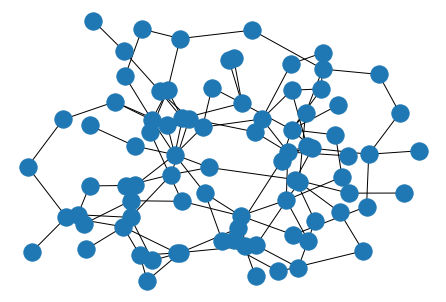

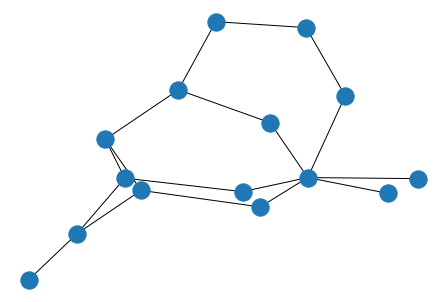

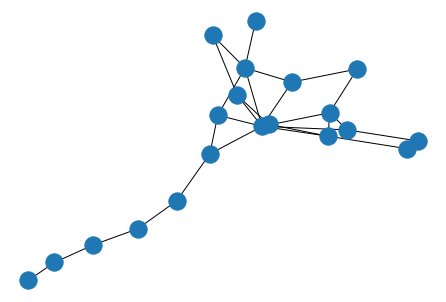

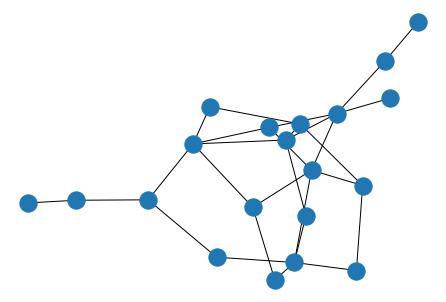

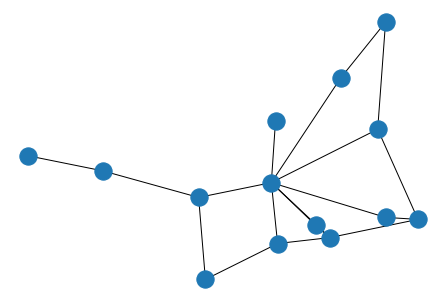

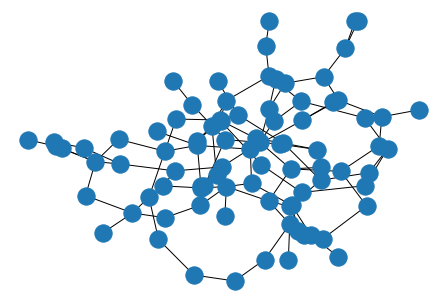

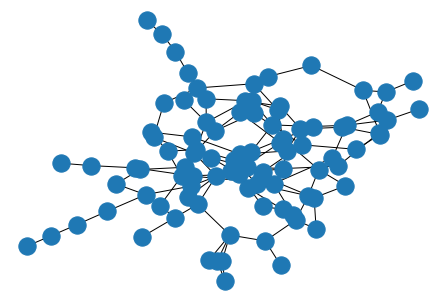

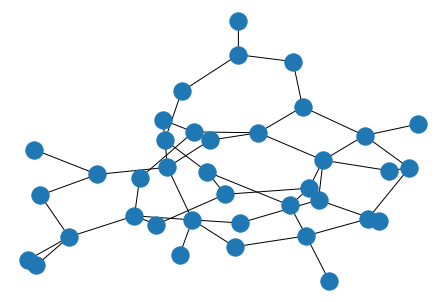

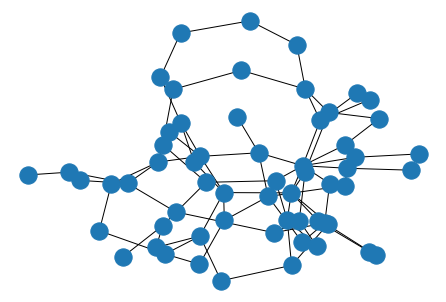

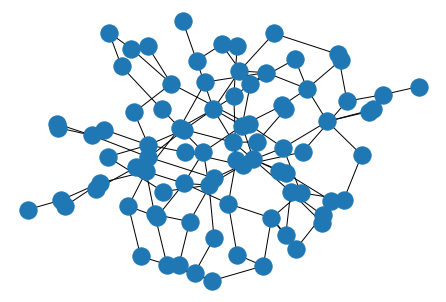

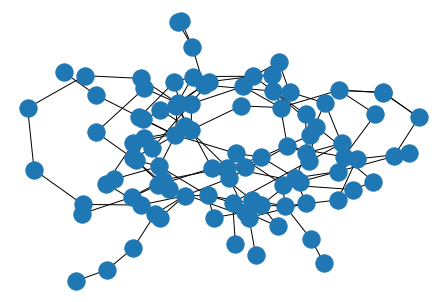

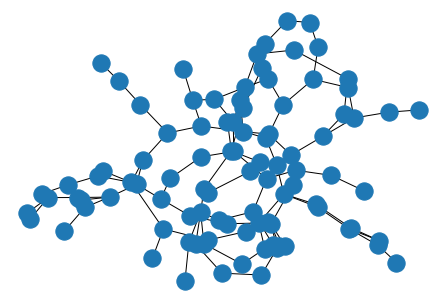

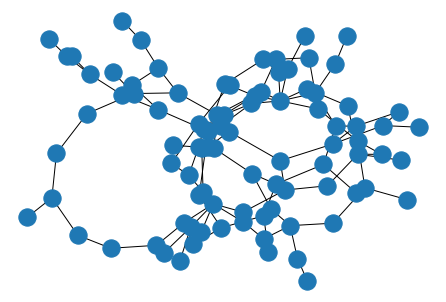

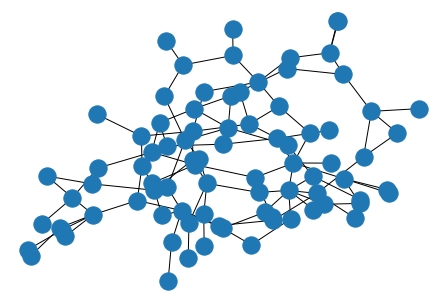

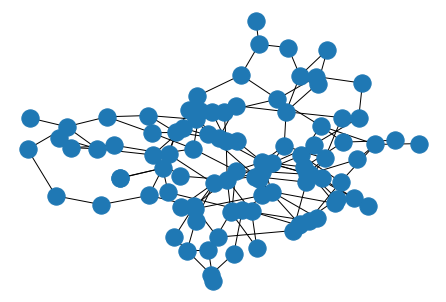

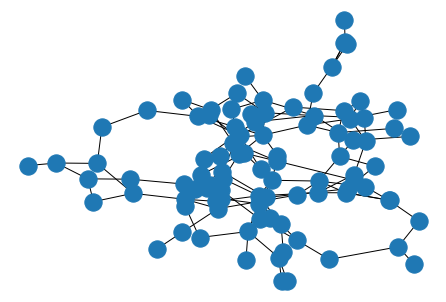

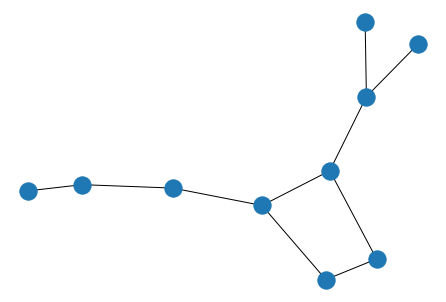

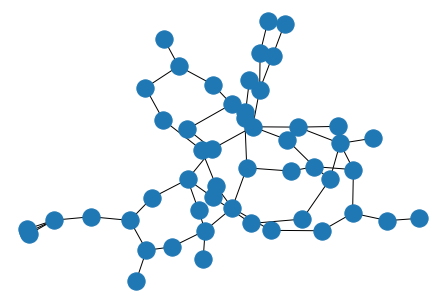

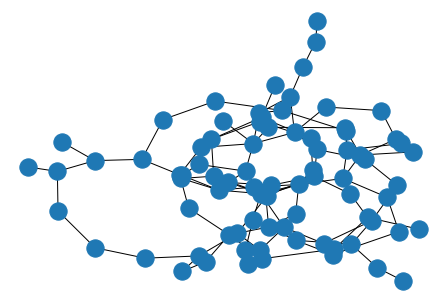

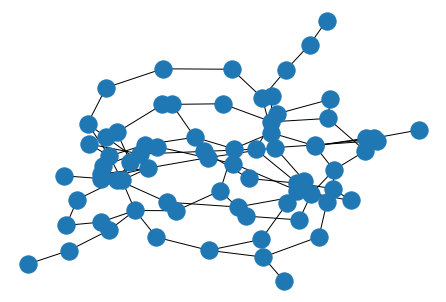

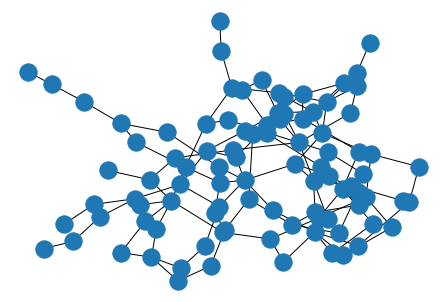

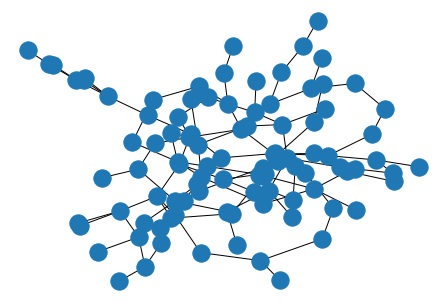

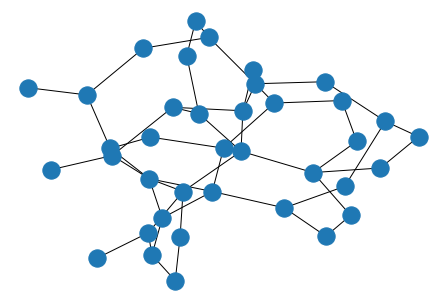

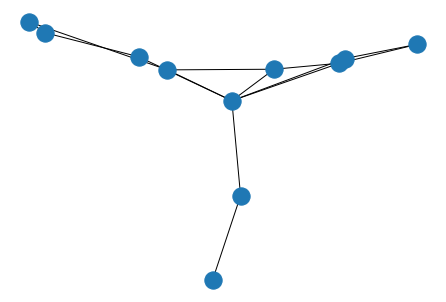

Error in callback <function flush_figures at 0x7f17661e3170> (for post_execute):


KeyboardInterrupt: 

In [26]:
folder_name = f'{config["test"]["name"]}_test'
test_loss = []
test_loss_ratio=[]
for test_idx in tqdm(range(10000, 11000)):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device)
    gt_loss = ground_truth.loc[test_idx][0]
    loss_ratio = (loss - gt_loss) / gt_loss
    test_loss.append(loss)
    test_loss_ratio.append(loss_ratio)
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_{test_idx}_{loss}.png') 
#     node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
#     plt.figure()
#     nx.draw(G_vis, node_pos)
#     plt.savefig(f'{folder_name}/{test_idx}.png')

print(np.nanmean(test_loss), np.nanstd(test_loss))

print(np.nanmean(test_loss_ratio), np.nanstd(test_loss_ratio))

In [33]:
test_loss_threshold = 10000
test_loss_ratio_threshold = 400
test_loss_filtered = np.array(test_loss)
test_loss_ratio_filtered = np.array(test_loss_ratio)
test_loss_filtered = test_loss_filtered[test_loss_filtered < test_loss_threshold]
test_loss_ratio_filtered = test_loss_ratio_filtered[test_loss_ratio_filtered < test_loss_ratio_threshold]

In [34]:
print(np.nanmean(test_loss_filtered), np.nanstd(test_loss_filtered))
print(np.nanmean(test_loss_ratio_filtered), np.nanstd(test_loss_ratio_filtered))

133.68725725725727 136.6775020303127
0.2128654428933248 0.620179202373195


In [ ]:
losses = []
loss_ratios = []
for test_idx in tqdm(range(10000, 11000)):
    G_vis = G_list[test_idx]
    node_pos, loss = evaluate(model, data_list[test_idx], criterion, device)
    gt_loss = ground_truth.loc[test_idx][0]
    loss_ratio = (loss - gt_loss) / gt_loss
    losses += [loss]
    loss_ratios += [loss_ratio]

In [ ]:
np.mean(losses), np.std(losses)

In [ ]:
np.mean(loss_ratios), np.std(loss_ratios)

In [ ]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth), data_list[idx])
    pred_loss += criterion(torch.tensor(pred), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

In [ ]:
type(data_list[9999].x)

In [ ]:
iterations = 5
losses = []
folder_name = f'{config["test"]["name"]}_iterative_test'
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')
    for i in range(iterations):
        node_pos, loss = evaluate(model, data_list[test_idx], criterion, device) 
        data_list[test_idx].x = torch.tensor(node_pos,dtype=torch.float)
    losses += [loss]
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_iter_model_{test_idx}_{loss}.png')

In [ ]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

In [ ]:
np

In [ ]:
class EnergyLossScaled(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data, scale):
        edge_attr = data.edge_attr
        # convert per-node positions to per-edge positions
        start, end, n_nodes = node2edge(p, data)
        
        start *= scale
        end *= scale
        
        start_x = start[:, 0]
        start_y = start[:, 1]
        end_x = end[:, 0]
        end_y = end[:, 1]
        
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        
        term1 = (start_x - end_x) ** 2
        term2 = (start_y - end_y) ** 2
        term3 = l ** 2
        term4 = 2 * l * (term1 + term2).sqrt()
        energy = k / 2 * (term1 + term2 + term3 - term4)
        return energy.sum()

In [ ]:
criterion_scaled = EnergyLossScaled()
criterion = EnergyLossVectorized()

In [ ]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth, device=device), data_list[idx])
    pred_loss += criterion(torch.tensor(pred, device=device), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

In [ ]:
for idx in [10898, 10904]:#tqdm(range(10000, 11000)):
    data, G = data_list[idx], G_list[idx]
    edge_attr = data.edge_attr
    pred, loss = evaluate(model, data, criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G, prog='neato')
    truth = np.array(list(pos_map.values()))

    start, end, n_nodes = node2edge(torch.tensor(truth, device=device), data)
    w = edge_attr[:, 1]
    d = edge_attr[:, 0]

    u2 = ((start - end) ** 2).sum(dim=1)

    s = (w * d * u2.sqrt()).sum() / (w * u2).sum()

    loss_gt = criterion_scaled(torch.tensor(truth, device=device), data, s)

    print(loss, loss_gt)

In [ ]:
def evaluate(model, data, criterion, device, idx):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        pred = model(data).detach()
        loss = criterion(pred,data).cpu().numpy()
        loss = round(float(loss),2)
    return pred.cpu().numpy(), loss

def graph_vis(G, node_pos):
    i = 0
    for n, p in node_pos:
        node = 'n' +str(i)
        G.nodes[node]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    
for test_idx in tqdm(list(range(10000, len(data_list)))):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device, test_idx)
    if loss > 10000:
        print(test_idx, loss, data_list[test_idx].num_nodes)
        graph_vis(G_vis, node_pos) 
        node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
        plt.figure()
        nx.draw(G_vis, node_pos)

# Visualization

In [ ]:
model = torch.load(f'../ckpt_{config["name"]}/epoch_{config["test"]["epoch"]}.pt', map_location=torch.device(device))

In [ ]:
idx = 0
G, data = G_list[idx], data_list[idx].to(device)

In [ ]:
out = model(data, output_hidden=True, numpy=True)
hidden = out[0:1] + out[2:11] + out[-1:]

# projected = list(map(pca_project, hidden))
for layer,i in enumerate(hidden):
    print(layer,i)

In [ ]:
list(model.parameters())